Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

**Answers are due by Tuesday, September 25, 2018**

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

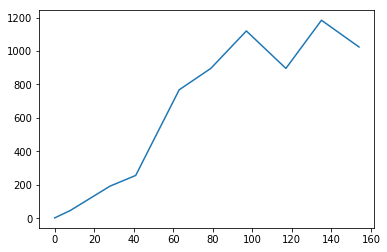

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using the Newton–Raphson approach to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

In [521]:
# Part 1
from scipy import optimize

# Logistic growth equation
def solveLogisticGrowth(initial_number, rate, capacity, time):
    return ((capacity*initial_number)/(initial_number+(capacity-initial_number)*np.exp(-1*rate*time)))

# Partial derivative of logistic growth equation with respect to rate
def d_rate(initial_number, rate, capacity, time):
    return((capacity*initial_number*time*(capacity-initial_number)*np.exp(-1*rate*time))/(initial_number+(capacity-initial_number)*np.exp(-1*rate*time))**2)

# Partial derivative of logistic growth equation with respect to capacity
def d_capacity(initial_number, rate, capacity, time):
    return(((initial_number**2)*np.exp(time*rate)*(np.exp(time*rate)-1))/(capacity+initial_number*(np.exp(time*rate)-1))**2)

# Generate predictions
def predict(func,initial_number, rate, capacity, timePoints):
    return(np.array([func(initial_number,rate,capacity,time) for time in timePoints]))
    
# The function to be optimized 
def solve_SSE(x,*args):
    endogenous=args[0]
    yHat=predict(solveLogisticGrowth,args[1],x[0],x[1],args[2])
    return(np.sum(np.square(yHat-np.array(endogenous))))

# Solve partial derivatives of SSE
def solve_dSSE(x,*args):
    endogenous=args[0]
    yHat=predict(solveLogisticGrowth,args[1],x[0],x[1],args[2])
    
    # Calculate predictions for partial of rate
    ratePartial=predict(d_rate,args[1],x[0],x[1],args[2])
    
    #Calculate predictions for partial of capacity
    capacityPartial=predict(d_capacity,args[1],x[0],x[1],args[2])
    
    return(np.array([np.sum(2*(yHat-np.array(endogenous))*ratePartial),np.sum(2*(yHat-np.array(endogenous))*capacityPartial)]))

def fitLogisticGrowth(endogenous,timePoints,rateInit,capacityInit, tol=1e-4, max_iter=10000):
    SSEdiff=1
    i = 0
    SSEprev=0
    rate=rateInit
    capacity=capacityInit
    initial_number=endogenous[0]
    
    while (SSEdiff > tol) and (i < max_iter):

        SSE=solve_SSE([rate,capacity],endogenous,initial_number,timePoints)
        dRate, dCapacity=solve_dSSE([rate,capacity],endogenous,initial_number,timePoints)
        
        # Shrink step size as SSE shirnks 
        r_step=SSE/1000000000000000
        c_step= SSE/100000000
        
        SSEdiff=np.abs(SSE-SSEprev)
        rate += -dRate*r_step
        capacity += -dCapacity*c_step
        SSEprev=SSE
        i+=1
        
    if i>=max_iter:
        print("Failed to Converge")
    
    return({"rate":rate,"capacity":capacity, "SSE":SSE})

In [522]:
results=fitLogisticGrowth(beetles,days,days[-1]/beetles[-1],max(beetles))
results

{'rate': 0.11795435223430668,
 'capacity': 1033.5564420634043,
 'SSE': 83240.49407026863}

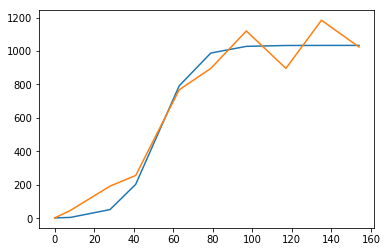

In [523]:
plt.plot(days, predict(solveLogisticGrowth,2,results["rate"],results["capacity"],days))
plt.plot(days,beetles)

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression

baseball = pd.read_table('data/textbook/baseball.dat', sep='\s+')

logsalary = baseball.salary.apply(np.log)
predictors = baseball.loc[:, 'average':]
nrows, ncols = predictors.shape

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there. I will award 5 bonus points to the best solution!

In [3]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon).values

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use pandas to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

In [292]:
import os
import numpy as np
import pandas as pd

# Set up file paths and parameters for file loading
path="/Users/matthewlenert/Documents/4F|Adv Stat Computing/Bios8366/data/ebola/"


# Record import column names in files and variables relevant to case/death count. 
# Case and death counts should include suspected and probable cases/deaths to avoid underestimating the scope of the outbreak

folders={"sl_data/":{"casesColVals":["new_suspected","new_probable","new_confirmed"]
                    ,"colNames":["date","variable","National"]
                    ,"deathColVals":["death_suspected","death_probable","death_confirmed"]}
         ,"guinea_data/":{"casesColVals":["New cases of suspects","New cases of probables","New cases of confirmed"]
                    ,"colNames":["Date","Description","Totals"]
                    ,"deathColVals":["New deaths registered","New deaths registered today (confirmed)","New deaths registered today (probables)","New deaths registered today (suspects)"]}
         ,"liberia_data/":{"casesColVals":["New Case/s (Suspected)","New Case/s (Probable)","New case/s (confirmed)"]
                    ,"colNames":["Date","Variable","National"]
                    ,"deathColVals":["Newly reported deaths"]}
        }



In [293]:
# Intialize output variable
countryDF=[]

# Loop over different country directories
for folder in folders:
    files = [f for f in os.listdir(path+folder)]
    
    columns=folders[folder]["colNames"]
    
    # Loop over files in country directory
    for f in files:
        df=pd.read_csv(path+folder+f,index_col=False)
        df=df.drop(columns[2],1)
        numericCols=[col for col in df.columns.values if col not in columns]
        
        # Convert death totals by province into integers
        death=df[df[columns[1]].isin(folders[folder]["deathColVals"])].drop(columns[1],1)
        death[numericCols]=death[numericCols].astype(np.float32)
        
        # Sum death totals by province to form national total
        death=death.groupby(columns[0]).sum()
        death["Deaths"]=death.sum(axis=1)
        
        # Add Country label
        death["Country"]=folder.split("_")[0]
        
        # Convert case totals by province into integers
        cases=df[df[columns[1]].isin(folders[folder]["casesColVals"])].drop(columns[1],1)
        cases[numericCols]=cases[numericCols].astype(np.float32)
        
        # Sum case total by province to form national total
        cases=cases.groupby(columns[0]).sum()
        death["Cases"]=cases.sum(axis=1)
        
        # Append to list to concatenate
        countryDF.append(death[["Country","Cases","Deaths"]])
         
# Concatenate rows into single dataframe and convert index to dateTime        
countryDF=pd.concat(countryDF,axis=0)
countryDF.index=pd.to_datetime(countryDF.index)    

# Add Country column to index and re-sort data to make the index functional
countryDF=countryDF.set_index(['Country'], append=True)
countryDF.sort_index(ascending=True, inplace=True)

In [295]:
countryDF